In [1]:
import os
import random
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from PIL import Image
from sklearn import decomposition
from torchvision import io
from torchvision.transforms.v2 import functional as F
from transformers import AutoImageProcessor, AutoModel

## Setup:

In [2]:
# Set images path
train_path = Path("../data/BrainTumor/train")
test_path = Path("../data/BrainTumor/test")
valid_path = Path("../data/BrainTumor/valid")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]

# Define datasets
datasets = {"Train": train_path, "Test": test_path, "Validation": valid_path}

## Explore images folder:

In [3]:
# Analyze directories
def analyze_dataset_directory(directory: Path, file_type: str = "images") -> None:
    subdirectory = directory / file_type
    files = (
        list(subdirectory.glob("*.jpg")) + list(subdirectory.glob("*.png"))
        if file_type == "images"
        else list(subdirectory.glob("*.txt"))
    )
    counter = []

    if file_type == "images":
        for file in files:
            with Image.open(file) as img:
                counter.append(img.size)
        print(f"Images in {directory.name}: {len(files)}, Different sizes: {set(counter)}")

    elif file_type == "labels":
        for file in files:
            with open(file, "r") as f:
                labels = f.readlines()
            counter.append(len(labels))
        print(f"Labels in {directory.name}: {len(files)}, Labels per file: {set(counter)}")


for dataset_name, path in datasets.items():
    print(f"\n{dataset_name} Dataset:")
    analyze_dataset_directory(path, "images")
    analyze_dataset_directory(path, "labels")



Train Dataset:
Images in train: 2144, Different sizes: {(640, 640)}
Labels in train: 2144, Labels per file: {1}

Test Dataset:
Images in test: 308, Different sizes: {(640, 640)}
Labels in test: 308, Labels per file: {1}

Validation Dataset:
Images in valid: 612, Different sizes: {(640, 640)}
Labels in valid: 612, Labels per file: {1}


In [4]:
# Check that all images are labeled
def image_has_label(directory: Path) -> None:
    images_path = directory / "images"
    labels_path = directory / "labels"

    for image_path in images_path.glob("*.jpg"):
        label_file = labels_path / f"{image_path.stem}.txt"
        if not label_file.exists():
            print(f"Image {image_path} does not have a corresponding label file.")

    print(f"All images in {images_path} have corresponding label files in {labels_path}")


for dataset_name, path in datasets.items():
    print(f"\n{dataset_name} Dataset:")
    image_has_label(path)


Train Dataset:
All images in ../data/BrainTumor/train/images have corresponding label files in ../data/BrainTumor/train/labels

Test Dataset:
All images in ../data/BrainTumor/test/images have corresponding label files in ../data/BrainTumor/test/labels

Validation Dataset:
All images in ../data/BrainTumor/valid/images have corresponding label files in ../data/BrainTumor/valid/labels


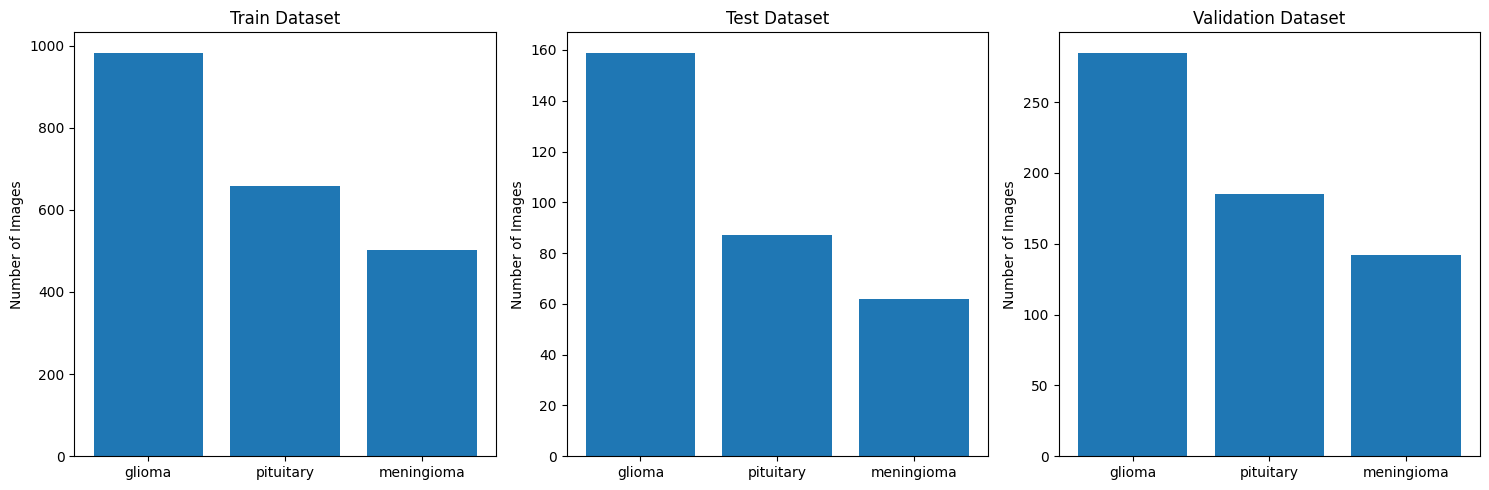

In [5]:
# Explore classes and coordinates
def get_image_label_info(labels_file: Path) -> Tuple[str, List[float]]:
    with open(labels_file, "r") as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        entries = line.strip().split()
        # Extract class id (first entry)
        class_id = int(entries[0])

        # Coordinates are in pairs: x1, y1, x2, y2, ..., xn, yn
        coordinates = [float(i) for i in entries[1:]]
        x_coords = coordinates[::2]
        y_coords = coordinates[1::2]

        # Get bounding box from polygon
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        # Convert to center format
        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        labels.append(
            {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
        )

    return labels


def explore_classes_and_polygon_coordinates(labels_folder: Path) -> Tuple[Dict[str, str], Dict[str, List[float]]]:
    classes = {}
    coordinates = {}

    for labels_file in labels_folder.glob("*.txt"):
        labels = get_image_label_info(labels_file)
        classes[labels_file.stem] = CLASSES_NAMES[labels[0]["class_id"]]
        coordinates[labels_file.stem] = labels[0]["vertices"]

    return classes, coordinates


# Plot all three class distributions
def plot_class_distribution(train_classes: dict, test_classes: dict, valid_classes: dict) -> None:
    plt.figure(figsize=(15, 5))

    dataset_names = ["Train", "Test", "Validation"]

    for i, dct in enumerate([train_classes, test_classes, valid_classes]):
        class_counts = {}
        for class_name in dct.values():
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        # Order classes by frequency
        class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

        plt.subplot(1, 3, i + 1)
        plt.bar(class_counts.keys(), class_counts.values())
        plt.ylabel("Number of Images")
        plt.title(f"{dataset_names[i]} Dataset")

    plt.tight_layout()
    plt.show()


train_classes, train_coordinates = explore_classes_and_polygon_coordinates(train_path / "labels")
test_classes, test_coordinates = explore_classes_and_polygon_coordinates(test_path / "labels")
valid_classes, valid_coordinates = explore_classes_and_polygon_coordinates(valid_path / "labels")
plot_class_distribution(train_classes, test_classes, valid_classes)


Image: 1236_jpg.rf.3b7ebc18f7e11fdbd9055a9ca09663cb
First label Class: pituitary, ID: 2
Image size: 640 x 640
First label number of polygon vertices: 8
First label raw coordinates: [(0.6155988859375, 0.47353760468750006), (0.6601671312499999, 0.4206128140625), (0.6601671312499999, 0.3788300828125), (0.632311978125, 0.36490250625), (0.57381615625, 0.37604456875), (0.571030640625, 0.43454039062499994), (0.59888579375, 0.479108634375), (0.6155988859375, 0.47353760468750006)]


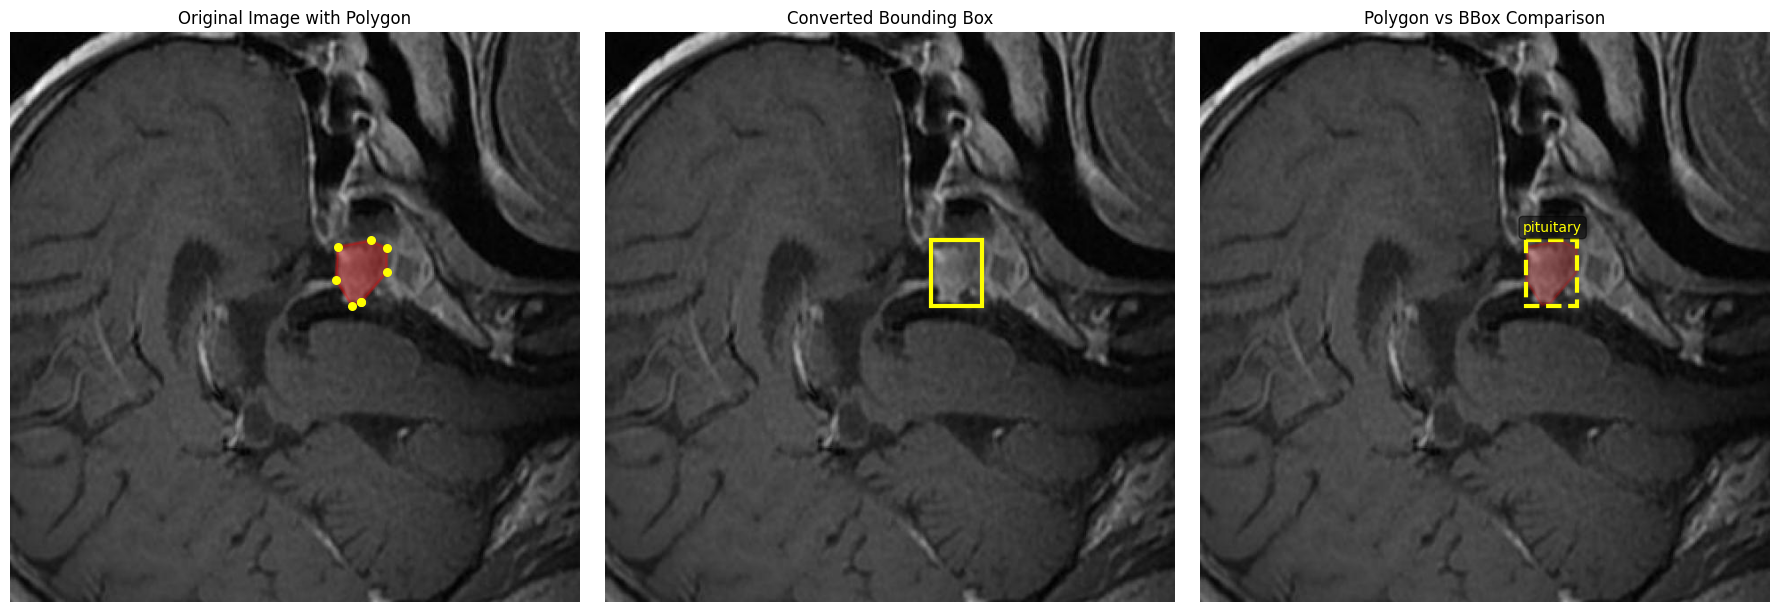

In [6]:
def visualize_polygon_vs_bbox(image_name: str, image_split: str = "train") -> None:
    # Load image and label
    image = io.read_image(f"../data/BrainTumor/{image_split}/images/{image_name}.jpg")
    label_file = f"../data/BrainTumor/{image_split}/labels/{image_name}.txt"

    labels = get_image_label_info(label_file)
    first_class_id, first_vertices = labels[0]["class_id"], labels[0]["vertices"]
    h, w = F.get_size(image)

    print(f"Image: {image_name}")
    print(f"First label Class: {CLASSES_NAMES[first_class_id]}, ID: {first_class_id}")
    print(f"Image size: {w} x {h}")
    print(f"First label number of polygon vertices: {len(first_vertices)}")
    print(f"First label raw coordinates: {first_vertices[:10]}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original image with polygon overlay
    ax1 = axes[0]
    ax1.imshow(image.permute(1, 2, 0).numpy())
    ax1.set_title("Original Image with Polygon")
    ax1.axis("off")

    # 2. Converted bounding box
    ax2 = axes[1]
    ax2.imshow(image.permute(1, 2, 0).numpy())
    ax2.set_title("Converted Bounding Box")
    ax2.axis("off")

    # 3. Comparison overlay
    ax3 = axes[2]
    ax3.imshow(image.permute(1, 2, 0).numpy())
    ax3.set_title("Polygon vs BBox Comparison")
    ax3.axis("off")

    for label in labels:
        class_id, bbox, vertices = label["class_id"], label["bbox"], label["vertices"]

        # Scale coordinates to image size
        x_coords = [vertice[0] * w for vertice in vertices]
        y_coords = [vertice[1] * h for vertice in vertices]

        # Create polygon patch
        polygon_points = list(zip(x_coords, y_coords))
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.3, closed=True)
        ax1.add_patch(polygon)

        # Mark vertices
        ax1.scatter(x_coords, y_coords, color="yellow", s=30, zorder=5)

        # Scale to image size
        cx, cy, bw, bh = bbox
        cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

        # Convert to corner format for visualization
        x_min_scaled = cx - bw / 2
        y_min_scaled = cy - bh / 2

        # Draw bounding box
        rect = patches.Rectangle(
            (x_min_scaled, y_min_scaled), bw, bh, linewidth=3, edgecolor="yellow", facecolor="none"
        )
        ax2.add_patch(rect)

        # Draw both polygon and bounding box
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True)
        ax3.add_patch(polygon)

        # Add class name tag to bounding box
        ax3.text(
            x_min_scaled + 30,
            y_min_scaled - 10,
            CLASSES_NAMES[class_id],
            color="yellow",
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.5),
        )
        rect = patches.Rectangle(
            (x_min_scaled, y_min_scaled),
            bw,
            bh,
            linewidth=3,
            edgecolor="yellow",
            facecolor="none",
            linestyle="--",
        )
        ax3.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Run the visualization
train_images_path = train_path / "images"
train_images = list(train_images_path.glob("*.jpg"))
sample = random.choice(train_images)
image_name = sample.stem

visualize_polygon_vs_bbox(image_name)

## Model Loading:

In [7]:
def load_model_and_processor(model_name: str, image_name: str) -> Tuple[AutoModel, AutoImageProcessor]:
    img = Image.open(f"../data/BrainTumor/train/images/{image_name}.jpg")
    processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True, token=os.getenv("HF_TOKEN"))
    model = AutoModel.from_pretrained(model_name)

    print(
        torchinfo.summary(
            model,
            input_data=torch.randn(1, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            depth=4,
            row_settings=["var_names"],
        )
    )

    print(f"Processor:\n{processor}\n")

    processed_image = processor(images=img, return_tensors="pt")
    print(f"Processed image shape:\n{processed_image['pixel_values'].shape}\n")

    return model, processor

In [8]:
dinov2, dinov2_processor = load_model_and_processor("facebook/dinov2-base", image_name)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
Dinov2Model (Dinov2Model)                                    [1, 3, 224, 224]          [1, 768]                  --                        True
├─Dinov2Embeddings (embeddings)                              [1, 3, 224, 224]          [1, 257, 768]             1,053,696                 True
│    └─Dinov2PatchEmbeddings (patch_embeddings)              [1, 3, 224, 224]          [1, 256, 768]             --                        True
│    │    └─Conv2d (projection)                              [1, 3, 224, 224]          [1, 768, 16, 16]          452,352                   True
│    └─Dropout (dropout)                                     [1, 257, 768]             [1, 257, 768]             --                        --
├─Dinov2Encoder (encoder)                                    [1, 257, 768]             [1, 257, 768]             --                  

In [9]:
dinov2.config

Dinov2Config {
  "apply_layernorm": true,
  "architectures": [
    "Dinov2Model"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 518,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_features": [
    "stage12"
  ],
  "out_indices": [
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "transformers_version": "4.56.0",
  "use_mask_token": true,
  "use_swiglu_ffn": false
}

In [10]:
dinov3, dinov3_processor = load_model_and_processor("facebook/dinov3-vitb16-pretrain-lvd1689m", image_name)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
DINOv3ViTModel (DINOv3ViTModel)                         [1, 3, 224, 224]          [1, 768]                  --                        True
├─DINOv3ViTEmbeddings (embeddings)                      [1, 3, 224, 224]          [1, 201, 768]             4,608                     True
│    └─Conv2d (patch_embeddings)                        [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─DINOv3ViTRopePositionEmbedding (rope_embeddings)      [1, 3, 224, 224]          [196, 64]                 --                        --
├─ModuleList (layer)                                    --                        --                        --                        True
│    └─DINOv3ViTLayer (0)                               [1, 201, 768]             [1, 201, 768]             --                        True
│    │    └─LayerNorm (n

In [11]:
dinov3.config

DINOv3ViTConfig {
  "architectures": [
    "DINOv3ViTModel"
  ],
  "attention_dropout": 0.0,
  "drop_path_rate": 0.0,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "key_bias": false,
  "layer_norm_eps": 1e-05,
  "layerscale_value": 1.0,
  "mlp_bias": true,
  "model_type": "dinov3_vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "num_register_tokens": 4,
  "patch_size": 16,
  "pos_embed_jitter": null,
  "pos_embed_rescale": 2.0,
  "pos_embed_shift": null,
  "proj_bias": true,
  "query_bias": true,
  "rope_theta": 100.0,
  "transformers_version": "4.56.0",
  "use_gated_mlp": false,
  "value_bias": true
}

In [12]:
# Set random seed
random.seed(5)

# Get n random image paths
num_images = 5
img_dir = Path("../data/BrainTumor/train/images")
img_paths = list(img_dir.glob("*.jpg"))
selected_imgs = random.sample(img_paths, num_images)

# Load images
imgs = [Image.open(p) for p in selected_imgs]
labels = [f"../data/BrainTumor/train/labels/{p.stem}.txt" for p in selected_imgs]


def visualize_embeddings(
    model: AutoModel, processor: AutoImageProcessor, images: List[Image.Image] = imgs, labels: List[str] = labels
) -> None:
    # Preprocess images
    inputs = processor(images=images, return_tensors="pt")

    # Get vertices for all images
    vertices_list = [get_image_label_info(label)[0]["vertices"] for label in labels]

    # Scale coordinates to image size
    w = images[0].width
    h = images[0].height

    # Extract patch embeddings for all images
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    if model.config.model_type == "dinov2":
        feature_maps = outputs.last_hidden_state[:, 1:, :]
    elif model.config.model_type == "dinov3_vit":
        feature_maps = outputs.last_hidden_state[:, 5:, :]

    # Stack all patches from all images
    batch_size, num_patches, embed_dim = feature_maps.shape
    all_patches = feature_maps.reshape(-1, embed_dim)

    print(f"Feature maps shape: {feature_maps.shape} [batch_size, num_patches, embed_dim]")
    print(f"All patches shape: {all_patches.shape} [batch_size*num_patches, embed_dim]")
    # Apply PCA to all patches
    pca = decomposition.PCA(n_components=3)
    all_pca = pca.fit_transform(all_patches)

    # PCA variance
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    # Standardize PCA results and normalize to [0, 1]
    all_pca_std = (all_pca - all_pca.mean(0)) / (all_pca.std(0) + 1e-8)
    all_pca_std_norm = (all_pca_std - all_pca_std.min(0)) / (np.ptp(all_pca_std, axis=0) + 1e-8)

    # Split back to images with improved normalization
    num_patches_side = int(np.sqrt(num_patches))
    pca_imgs_std = all_pca_std_norm.reshape(batch_size, num_patches, 3)
    pca_imgs_std = pca_imgs_std.reshape(batch_size, num_patches_side, num_patches_side, 3)

    # Apply adaptive background masking based on the first principal component
    fig, axs = plt.subplots(4, batch_size, figsize=(4 * batch_size, 12))

    for i in range(batch_size):
        # Compute adaptive threshold for background masking
        first_pc = pca_imgs_std[i][..., 0]
        threshold = np.percentile(first_pc, 50)  # Use 50th percentile as threshold

        # Apply background mask
        background_mask = first_pc > threshold
        pca_img_masked = pca_imgs_std[i].copy()
        pca_img_masked[background_mask] = 0

        # Compute cosine similarity between patch features
        image_patches = feature_maps[i]  # [num_patches, embed_dim]
        patches_norm = torch.nn.functional.normalize(image_patches, p=2, dim=1)
        similarity_matrix = torch.mm(patches_norm, patches_norm.T)

        # Use center patch as reference
        center_idx = similarity_matrix.shape[0] // 2
        center_similarities = similarity_matrix[center_idx, :]
        similarity_map = center_similarities.reshape(num_patches_side, num_patches_side)

        # Original PCA (no masking)
        axs[0, i].imshow(pca_imgs_std[i])
        axs[0, i].set_title(f"PCA (std norm) {i + 1}")

        # PCA with adaptive background masking
        axs[1, i].imshow(pca_img_masked)
        axs[1, i].set_title(f"PCA (masked) {i + 1}")
        # axs[1, i].contour(first_pc, levels=[threshold], colors="red", linewidths=1)

        # Feature similarity
        axs[2, i].imshow(similarity_map.cpu().numpy(), cmap="hot", interpolation="bilinear")
        axs[2, i].set_title(f"Feature Similarity {i + 1}")

        # Original image with polygon overlay
        x_coords = [vertice[0] * w for vertice in vertices_list[i]]
        y_coords = [vertice[1] * h for vertice in vertices_list[i]]
        polygon_points = list(zip(x_coords, y_coords))
        polygon = patches.Polygon(polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True)

        axs[3, i].imshow(images[i])
        axs[3, i].set_title(f"Original {i + 1}")
        axs[3, i].add_patch(polygon)

    plt.tight_layout()
    plt.show()

Feature maps shape: torch.Size([5, 256, 768]) [batch_size, num_patches, embed_dim]
All patches shape: torch.Size([1280, 768]) [batch_size*num_patches, embed_dim]
PCA explained variance ratio: [0.11963072 0.09923572 0.08758808]
Total variance explained: 0.306


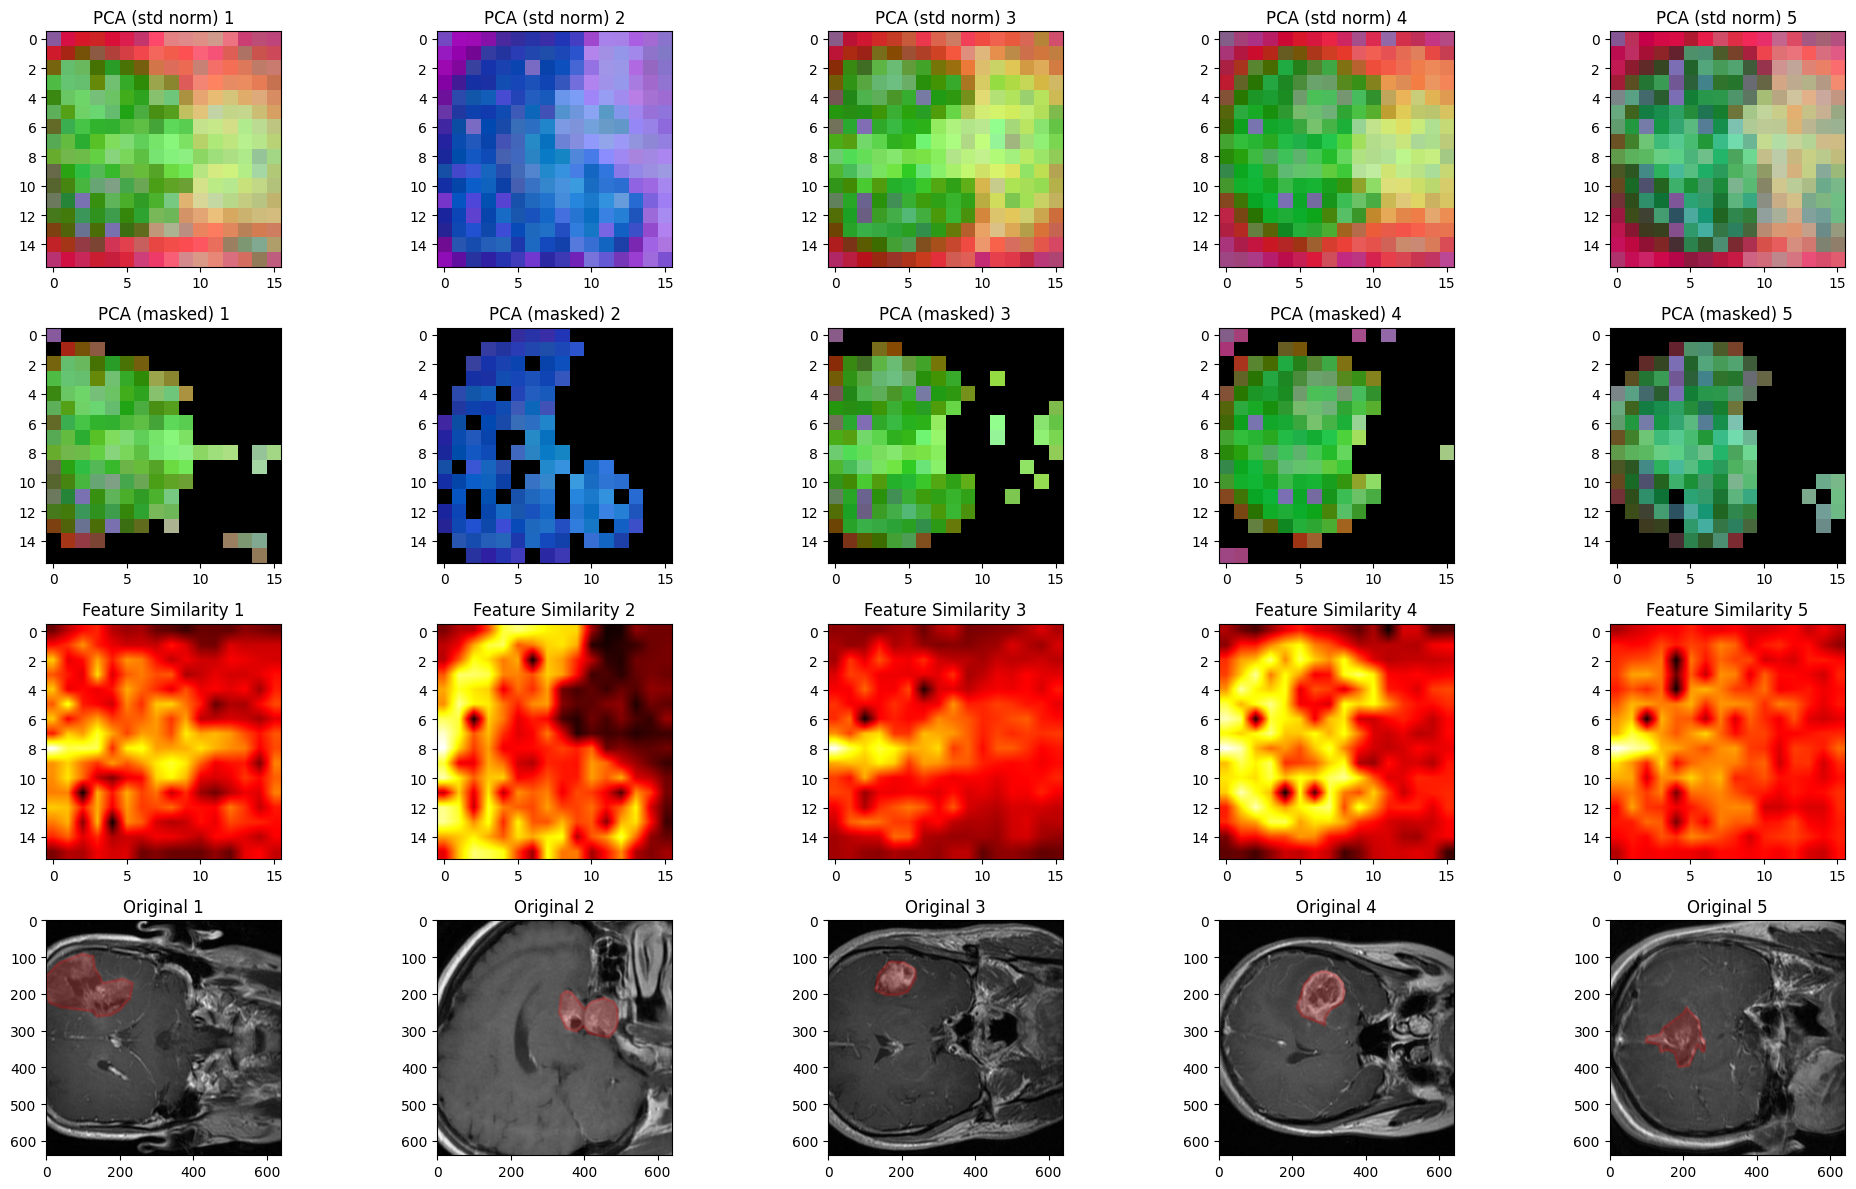

In [13]:
visualize_embeddings(dinov2, dinov2_processor, images=imgs)

Feature maps shape: torch.Size([5, 196, 768]) [batch_size, num_patches, embed_dim]
All patches shape: torch.Size([980, 768]) [batch_size*num_patches, embed_dim]
PCA explained variance ratio: [0.1744391  0.11660195 0.09427083]
Total variance explained: 0.385


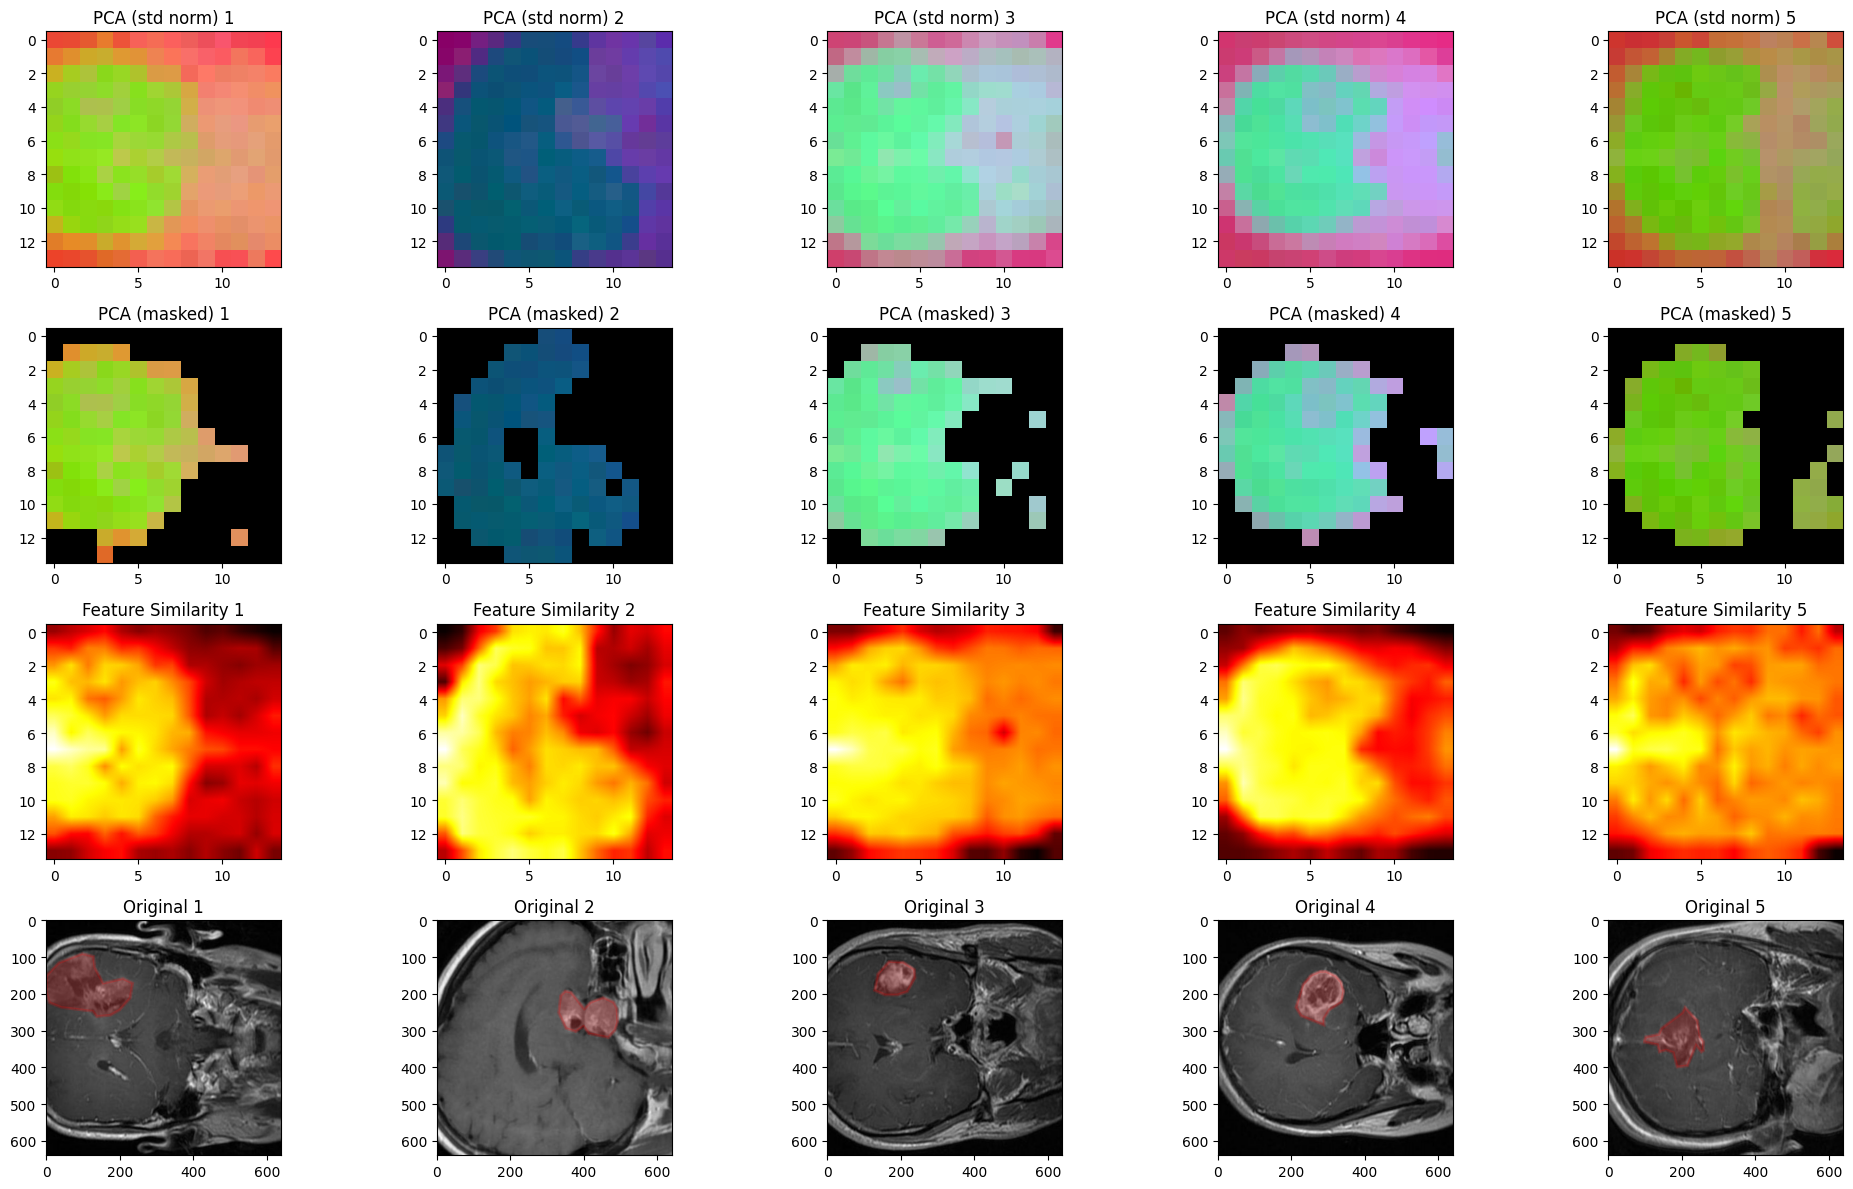

In [14]:
visualize_embeddings(dinov3, dinov3_processor, images=imgs)